# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Asset Price Forecast using the ARIMA model 

Predicting Asset Price is a challenging but exciting task considering the reward when the predictions go in line with the actual market data. ARIMA models try to model and predict future prices using past prices. After completing the notebook, you will forecast asset price using tuned ARIMA model, evaluate model performance, and compare the forecasted and actual values.

In this notebook, you will perform the following steps:

1. [Get the Stock data](#data)
2. [Analyze Time Series](#analyze)
3. [Stationarize Time Series](#stationarize)
4. [Search Optimal Parameters](#grid_search)
5. [Forecast using ARIMA model](#forecast)
6. [Model Performance](#performance)

## Step 1: Get Stock Data<a id='data'></a>

In [1]:
# Import Pandas Datareader
import pandas_datareader as pdr

# Set the start and end date
start_date = '01-Jan-10'
end_date = '01-Feb-20'

# Set the ticker
ticker = 'V'  # VISA

# Using Yahoo Finance API
data = pdr.get_data_yahoo(ticker, start_date, end_date)['Adj Close']

# Print the top 5 rows of the pandas series
data.head()

Date
2009-12-31    20.213949
2010-01-04    20.371117
2010-01-05    20.137684
2010-01-06    19.867273
2010-01-07    20.052168
Name: Adj Close, dtype: float64

## Step 2: Analyze the time series<a id='analyze'></a>

In [2]:
# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 7)
plt.style.use('seaborn-darkgrid')

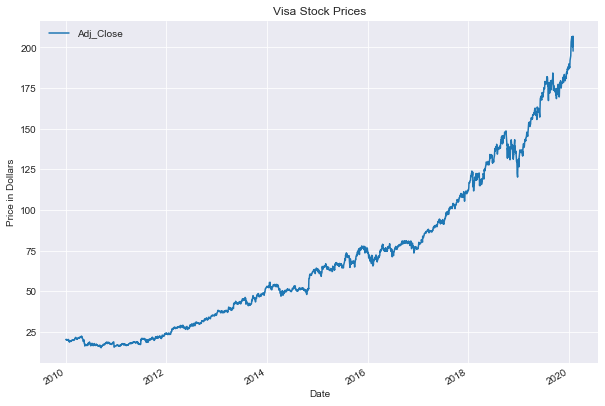

In [3]:
# Plot the Adjusted Close Visa stock price
data.plot(figsize=(10, 7))
plt.title('Visa Stock Prices')
plt.ylabel('Price in Dollars')
plt.legend(['Adj_Close'])
plt.show()

Time series is increasing trend hence not stationary. We can confirm this by using the Augmented Dickey-Fuller (ADF) Test, as well as by plotting the Autocorrelation Function (ACF) plot (visual check).

Since modelling involves estimating parameters and if the series is not stationary, there are too many parameters to estimate hence difficult to model. Thus stationarity of series is an important pre-requisite for modelling a time series. 

### Augmented Dickey-Fuller Test
The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05), then you reject the null hypothesis and infer that the time series is indeed stationary. Alternatively, if the p-value is greater than 0.05, we cannot reject the null hypothesis.

In [4]:
# Import adfuller
from statsmodels.tsa.stattools import adfuller

# Probability value of observing the result in our data by chance
p_value = adfuller(data)[1]

if p_value > 0.05:
    print(
        "The p-value is: {p_value} > 0.05, hence time series is not stationary.".format(p_value=p_value))
else:
    print("Time series is stationary.")

The p-value is: 1.0 > 0.05, hence time series is not stationary.


### Autocorrelation Function Plot
ACF plot is a visual representation of autocorrelations between different lags, where a lag 'k' autocorrelation is the correlation between values of time series that are k-period apart. If the autocorrelations are positive for many lags (10 or more), the series needs further differencing.

In [5]:
# Import plot_acf
from statsmodels.graphics.tsaplots import plot_acf

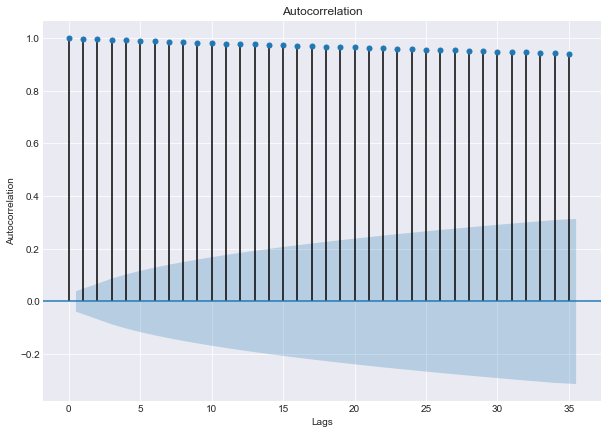

In [6]:
# ACF plot of original asset price series
plt.rcParams["figure.figsize"] = (10, 7)
plot_acf(data)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

Both the ADF test and ACF plot confirm that our time series is indeed non-stationary.

## Step 3: Stationarize the time series<a id='stationarize'></a>

We will plot first order differenced time series to check if resulted series is a stationary time series.

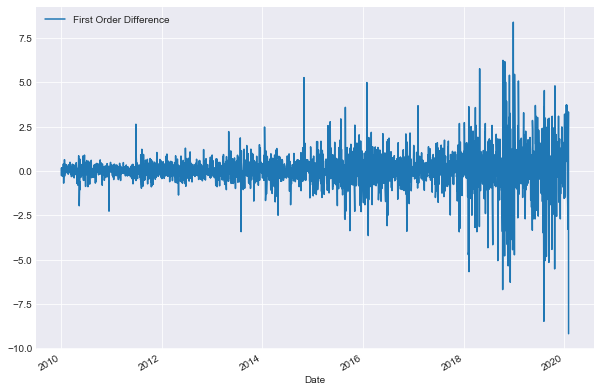

In [7]:
# Plot the First Order Difference of VISA stock price
data.diff().plot(figsize=(10, 7))
plt.xlabel('Date')
plt.legend(['First Order Difference'])
plt.show()

Above plot suggest that we can accept first order differenced time series as the required stationarized time series. One can also check ACF plot with any next level of differencing. The Autocorrelation values in that case goes into the far negative zone fairly quickly which indicates, the series might have been over-differenced. 

The above time series is not white noise since we can clearly observe data clustering. This also means we can work on a model so as to make the error residual close to white noise. If your time series is white noise, then, by definition, it is random. You cannot reasonably model it and make predictions. When forecast errors are white noise, it means that all of the signal information in the time series has been harnessed by the model in order to make predictions. All that is left is the random fluctuations that cannot be modeled. 

We'll plot density plot to confirm the stationarity of time series.

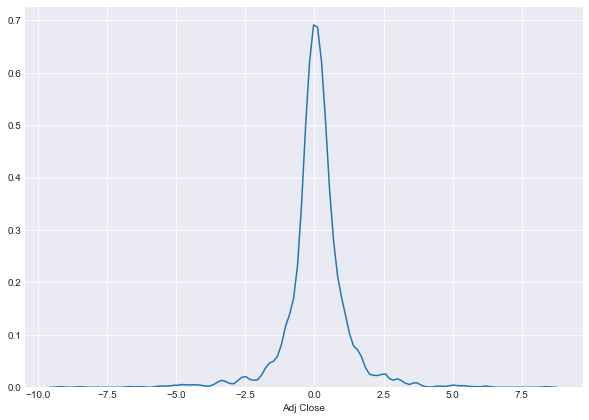

In [8]:
# Density Plot
plt.figure(figsize=(10, 7))
sns.distplot(data.diff().dropna(), hist=False, kde=True)
plt.show()

Density plot tells us that we have a near-zero mean and finite uniform variance. Thus satisfy the conditions for a series to be termed as stationary.

## Step 4: Search optimal parameters for ARIMA model<a id='grid_search'></a>

We find optimal ARIMA model parameter by observing Partial Autocorrelation Function(PACF)/ Autocorrelation Function(ACF) plots. 

One can iterate through various (p,q) values to finally select those giving a better information criterion (IC). Lower IC score is the better score.

### Performing train/test split
Before tuning the p,q parameter using time series data, we'll split it into train and test set.  

In [9]:
# Split data into train and test set
split = int(len(data)*0.90)
train_set, test_set = data[:split], data[split:]

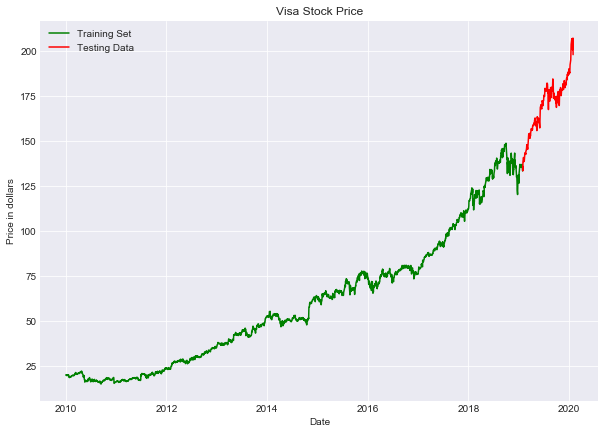

In [10]:
# Plot Train and Test set
plt.figure(figsize=(10, 7))
plt.title('Visa Stock Price')
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.plot(train_set, 'green')
plt.plot(test_set, 'red')
plt.legend(['Training Set', 'Testing Data'])
plt.show()

### Partial Autocorrelation Function Plot

A partial autocorrelation function refers to the degree of correlation between data in a time series, after controlling the effects of lagged observations. 

The number of significant lags for Partial Autocorrelation Function(PACF) plot suggests the order of the AR model. 

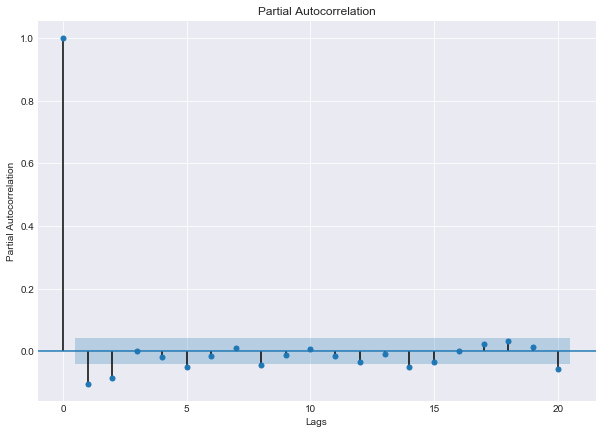

In [11]:
# Import plot_pacf
from statsmodels.graphics.tsaplots import plot_pacf

# Plot Partial Autocorrelation Function
plt.rcParams["figure.figsize"] = (10, 7)
plot_pacf(train_set.diff().dropna(), lags=20)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

A significant spike in Partial Autocorrelation values at lag 1 and lag 2 is observed in the above PACF plot, suggesting p=2 (AR term).

### Autocorrelation Function Plot
The number of significant lags for Autocorrelation Function(ACF) plot suggests the order of MA model.

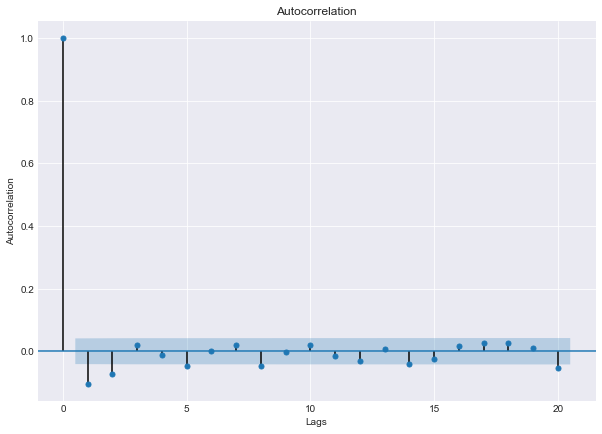

In [12]:
# Plot Autocorrelation Function
plt.rcParams["figure.figsize"] = (10, 7)
plot_acf(train_set.diff().dropna(), lags=20)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

Significant spike in Autocorrelation values is observed at lag 1 and lag 2 in above ACF plot, this suggest that q=2 (MA term). 

Both plots look similar and this signifies that the correlation induced due to further lagged observations is minimal. Though this may not hold true for other asset price time series. Reader is advised to experiment with different asset price time series to fully grasp this important concept.

### Information Criterion

When fitting ARIMA model, it is possible to increase the model performance by adding more parameters. But doing so may result in overfitting. When overfitted, model learns the details and noises in the training data to the extent that it negatively affects the model performance on test data. 

Information Criterion adds penalties for increasing model complexity. There are two popular Information Criterion, namely Akaike IC (AIC) and Bayesian IC (BIC). BIC imposes bigger penalties on models with more parameters as compared to AIC.

We'll tune p and q parameter separately using AIC and BIC both and check if they agree with each other.

### Tuning p(AR term) parameter

In [13]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import ARIMA
from statsmodels.tsa.arima_model import ARIMA

In [14]:
# Empty list to store aic/bic score
aic_p = []
bic_p = []

# p values
p = range(1, 6)  # [1,2,3,4,5]

# aic/bic score for different values of p
for i in p:
    model = ARIMA(train_set, order=(i, 1, 0))  # define AR model
    model_fit = model.fit(disp=-1)  # fit the model
    aic_temp = model_fit.aic  # get aic score
    bic_temp = model_fit.bic  # get bic score
    aic_p.append(aic_temp)  # append aic score
    bic_p.append(bic_temp)  # append bic score

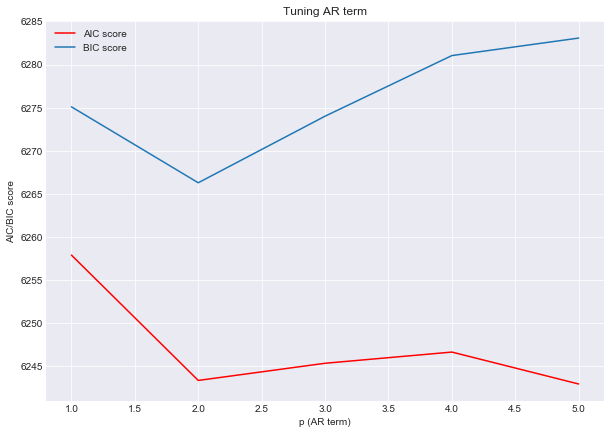

In [15]:
# Plot of AIC/BIC score for AR term
plt.figure(figsize=(10, 7))
plt.plot(range(1, 6), aic_p, color='red')
plt.plot(range(1, 6), bic_p)
plt.title('Tuning AR term')
plt.xlabel('p (AR term)')
plt.ylabel('AIC/BIC score')
plt.legend(['AIC score', 'BIC score'])
plt.show()

BIC score suggests that p=2. This is in line with our observation from the PACF plot. Note that AIC score is a little lower for p=5, but we'll be a bit conservative and continue with p=2.

### Tuning q(MA term) parameter

In [16]:
# Empty list to store aic/bic score
aic_q = []
bic_q = []

# q values
q = range(1, 6)  # [1,2,3,4,5]

# aic/bic score for different values of q
for i in q:
    model = ARIMA(train_set, order=(0, 1, i))  # define MA model
    model_fit = model.fit(disp=-1)  # fit the model
    aic_temp = model_fit.aic  # get aic score
    bic_temp = model_fit.bic  # get bic score
    aic_q.append(aic_temp)  # append aic score
    bic_q.append(bic_temp)  # append bic score

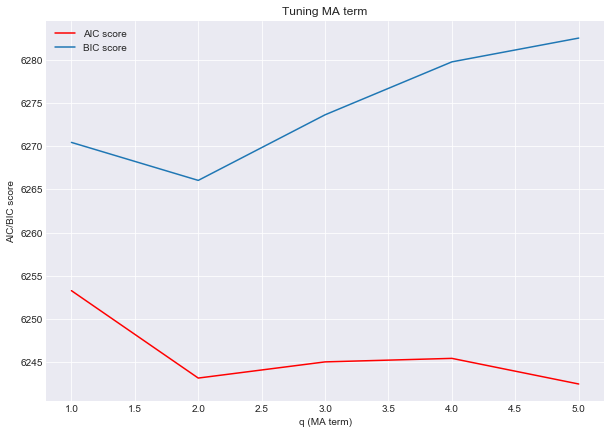

In [17]:
# Plot of AIC/BIC score for MA term
plt.figure(figsize=(10, 7))
plt.plot(range(1, 6), aic_q, color='red')
plt.plot(range(1, 6), bic_q)
plt.title('Tuning MA term')
plt.xlabel('q (MA term)')
plt.ylabel('AIC/BIC score')
plt.legend(['AIC score', 'BIC score'])
plt.show()

BIC score suggests that q=2. This is again in line with our observation from ACF plot.

## Build the ARIMA (p,d,q) model<a id='build'></a>

Thus our ARIMA model for p=2 and q=2 looks like : $$x'_t = b_0 + b_1 x'_{t-1} + b_2 x'_{t-2} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \epsilon_t$$

In [18]:
# Fit ARIMA model
model = ARIMA(train_set, order=(2,1,2))
model_fit_0 = model.fit()

## Step 5: Forecast using ARIMA model<a id='forecast'></a>

Forecasting using ARIMA is an iterative process where you have to update the train_set after each forecast and retrain the model everytime with an updated train_set to make next forecast. This is also known as Rolling Window forecast.

<font color='red'>Note: The below cell will take time to run.</font>

In [19]:
# Convert pandas series to list for rolling window forecast
past = train_set.tolist()
# Empty list for storing predictions
predictions = []

# Keeping only the first 50 data in the test dataset. You can run on the whole dataset, but it will take time to run.
test_set = test_set[:50]

# Perform rolling window forecast
for i in range(len(test_set)):
    model = ARIMA(past, order=(2, 1, 2))  # define model
    model_fit = model.fit(
        disp=-1, start_params=model_fit_0.params)  # fit the model
    forecast_results = model_fit.forecast()  # make forecast

    pred = forecast_results[0][0]  # [forecast, stderr, conf_int]
    predictions.append(pred)  # append prediction
    past.append(test_set[i])  # add test value to train set

In [20]:
# Predicted and actual Values
for i in range(0, 10):
    print('predicted={pred}, actual={test}'.format(
        pred=predictions[i], test=test_set[i]))

predicted=133.69000960692196, actual=135.8862762451172
predicted=135.798490898538, actual=133.32852172851562
predicted=133.58714074373407, actual=138.40452575683594
predicted=138.02420833732845, actual=139.7377166748047
predicted=139.25899445874825, actual=140.75486755371094
predicted=140.4763553310627, actual=139.7278289794922
predicted=139.59793595469884, actual=138.42428588867188
predicted=138.61047843051227, actual=138.6316680908203
predicted=138.67580524803645, actual=139.04641723632812
predicted=139.12000631756632, actual=140.22158813476562


## Step 6: Evaluate Model Performance<a id='performance'></a>

Error Residuals are indicative of the performance of our predictive model. Mean Squared Error is another metric used to measure model performance.

### Residual

It is the difference between the observed value of a variable at a time 't' and its predicted value based on information available before time 't'. Error residual for a model that is good at making predictions should resemble white noise. 

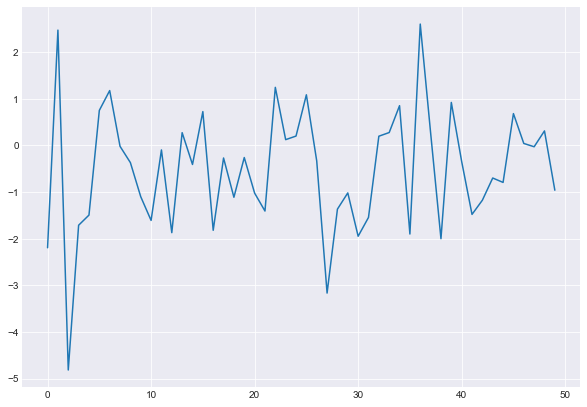

In [21]:
# Create empty list
residual = []

# Append residuals
for i in range(len(test_set)):
    residual.append(predictions[i]-test_set[i])

# Residual plot
plt.figure(figsize=(10, 7))
plt.plot(residual)
plt.show()

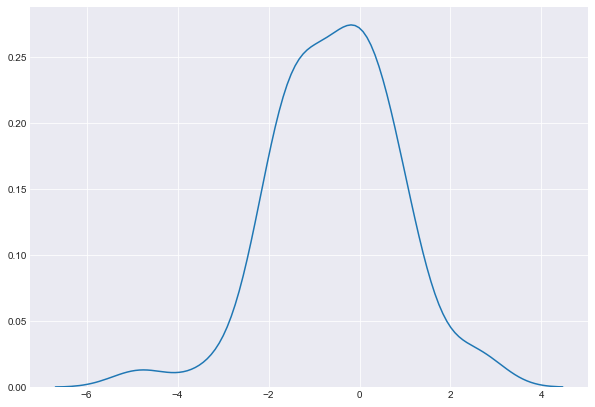

In [22]:
# Density plot
plt.figure(figsize=(10, 7))
sns.distplot(residual, hist=False, kde=True)
plt.show()

A model good at making predictions should have density plot similar to a Normal Distribution. The density plot suggests that we can still work on improving the predictive power of the ARIMA model.

### Mean Squared Error (MSE)

We use the Mean Squared Error(MSE) to measure backtesting results. It is the average squared difference between the estimated values and the actual values. Smaller the MSE, better the model performance. 

In [23]:
# Import Mean_Squared_Error
from sklearn.metrics import mean_squared_error

# Calculate MSE
error = mean_squared_error(test_set, predictions)
print('Test MSE: {mse}'.format(mse=error))

Test MSE: 2.033615560352085


### Plotting predictions and test data 

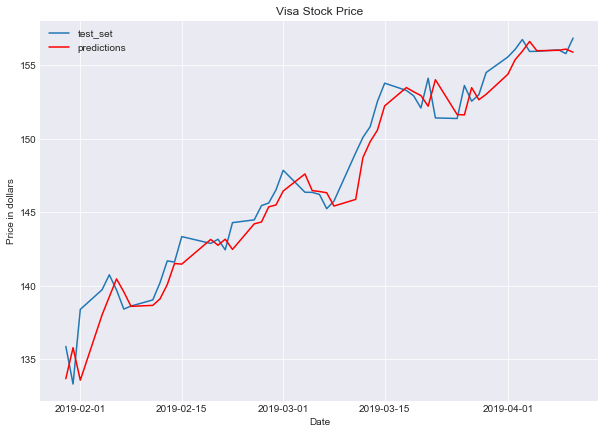

In [24]:
# Plot forecasted and actual values
plt.figure(figsize=(10, 7))
plt.plot(test_set)
plt.plot(test_set.index, predictions, color='red')
plt.title('Visa Stock Price')
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.legend(['test_set', 'predictions'])
plt.show()

Our model did a great job at predicting asset price of VISA stocks. Now you know how to use ARIMA model. You can go on and experiment with it and work on your understanding of the model.

1. Use different data sets: Try out the model on different data sets and compare model performance!
2. Information Criterion: We ignored higher-order p,q values suggested by AIC. Increase the grid size, try those values and compare results.
3. Rolling Window Forecast: We performed an expanding rolling window forecast, where new data points are added iteratively. There's another approach where one can drop initial points while adding new data points. This is termed as Fixed Rolling Window Forecast since the training window size is kept fixed. Try and compare the model performance.

In the next unit, you will learn to model volatility using the GARCH model. It is advised to thoroughly go through this notebook, as many concepts used in this notebook are directly used in GARCH modelling.
<br><br>